# Basic Usage of the `tyssue` library

## Easy creation of a 2D epithelial sheet

In [1]:
%matplotlib inline

# Core object
from tyssue.core.sheet import Sheet
# Simple 2D geometry
from tyssue.geometry.planar_geometry import PlanarGeometry
# Visualisation
from tyssue.draw.plt_draw import sheet_view

sheet = Sheet.planar_sheet_2d('basic2D', nx=6, ny=7,
                              distx=1, disty=1)
PlanarGeometry.update_all(sheet)
sheet.sanitize()


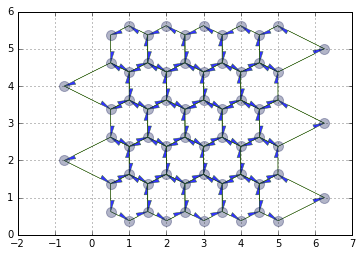

In [2]:
fig, ax = sheet_view(sheet)

## Datasets and specifications


The data associated with the mesh displayed above, i.e. the points positions,
the connectivity information, etc. is stored in pandas [DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) objects, hold together in the `datasets` dictionnary.


Depending on the geometry, the following dataframes are populated:
* `datasets["edge"]` or `sheet.edge_df`: The edge related dataframe contains 
 - the connectivity information: source and target vertices, associated face and (for thick tissues)
   the associated cell body.
 - geometry data associated with the edge, such as its length
 - any suplemental data, such as a color or a dynamical parameter (an elasticity for example)

* `datasets["vert"]` or `sheet.vert_df`: The vertices related dataframe. In the apical junction mesh above, 
  those are  the vertices at the cells junctions. It usually holds the coordinates of the points, 
  and geometry or dynamical data.

* `datasets["face"]` or `sheet.face_df`: The faces related dataframe. For a thin, 2D tissue, this corresponds to
  a cell of the epithelium, delimited by its edges. In thick, 3D models, one cell has several faces
  (the apical, sagittal and basal ones for a 3D monolayer, for example).
 
* `datasets["cell"]` or `sheet.cell_df`: The cells related dataframe, only for 3D, thick, epithelium.
  Each cell have several faces.
  
 

In [3]:
for element, data in sheet.datasets.items():
    print(element, ':', data.shape)

edge : (145, 8)
face : (25, 6)
vert : (65, 3)


In [4]:
sheet.datasets['edge'].head()

,length,face,dx,srce,trgt,dy,nz,sub_area
edge,,,,,,,,
0,1.397542,15,-1.25,5,2,-0.625,0.7500,0.37500
1,0.750000,20,0.00,4,5,-0.750,0.3750,0.18750
2,0.750000,15,0.00,0,6,0.750,0.4125,0.20625
3,0.750000,16,0.00,6,0,-0.750,0.3750,0.18750
4,0.559017,10,-0.50,0,3,-0.250,0.3125,0.15625


In [5]:
sheet.face_df.head()

,x,is_alive,num_sides,area,y,perimeter
face,,,,,,
0,1.00,True,6,1.00000,1.0,3.736068
1,2.00,True,6,1.00000,1.0,3.736068
2,3.00,True,6,1.00000,1.0,3.736068
3,4.00,True,6,1.00000,1.0,3.736068
4,5.05,True,5,1.28125,1.0,4.663119


We can use all the goodies from pandas DataFrames objects. For example, it is possible to 
compute the average edge length for each face like so:

In [6]:
sheet.edge_df.groupby('face')['length'].mean().head()

face
0    0.622678
1    0.622678
2    0.622678
3    0.622678
4    0.932624
Name: length, dtype: float64

**Specifications** are defined as a nested dictionnary, `sheet.specs`. For each element, the specification defines the columns of the corresonding DataFrame and their default values. An extra key at the root of the specification is called `"settings"`, and can hold specific parameters, for example the arguments for an energy minimization procedure.

In [7]:
sheet.specs

{'edge': {'dx': 0.0,
  'dy': 0.0,
  'face': 0,
  'length': 0.0,
  'nz': 0.0,
  'srce': 0,
  'trgt': 0},
 'face': {'area': 0.0,
  'is_alive': True,
  'num_sides': 6,
  'perimeter': 0.0,
  'x': 0.0,
  'y': 0.0},
 'settings': {},
 'vert': {'is_active': True, 'x': 0.0, 'y': 0.0}}

It is possible to update dynamically the data structure. For example, let's assume we want to put quasi-static model to minimize energy for the tyssue. For this we need three things.
* A specification dictionnary with the required data
* A model
* A solver

True


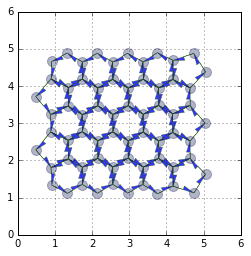

In [11]:
from tyssue.config.dynamics import quasistatic_plane_spec
from tyssue.dynamics.sheet_vertex_model import PlanarModel
from tyssue.solvers.sheet_vertex_solver import Solver

# Update the specs
sheet.update_specs(quasistatic_plane_spec())

# Find energy minimum
res = Solver.find_energy_min(sheet, 
                             PlanarGeometry,
                             PlanarModel)

print(res['success'])
fig, ax = sheet_view(sheet)

#### Upcasting

Geometry are physics computations often require to access for example
the cell related data on each of the cell's edges. The `Epithelium`
class and its derivatives defines utilities to make this,
i.e copying the area of each face to each of its edges:

In [23]:
print('Faces associated with the first edges:')
print(sheet.edge_df['face'].head())
print('\n')

# First edge associated face
face = sheet.edge_df.loc[0, 'face']

print('Area of cell # {}:'.format(int(face)))
print(sheet.face_df.loc[face, 'area'])

print('\n')
print('Upcasted areas over the edges:')
print(sheet.upcast_face(sheet.face_df['area']).head())

Faces associated with the first edges:
edge
0    15
1    20
2    15
3    16
4    10
Name: face, dtype: int64


Area of cell # 15:
0.534654926896


Upcasted areas over the edges:
edge
0    0.534655
1    0.582368
2    0.534655
3    0.573317
4    0.588597
Name: area, dtype: float64


The values have indeed be upcasted. This can also be done with the source and target vertices 
(`sheet.upcast_srce`, `sheet.upcast_trgt`) and cells in the 3D case (`sheet.upcast_cell`).

### Downcasting

This is usually done by `groupby` operations as shown above.
Syntactic sugar is available for summation, e.g. over every edges with a given source: 

In [24]:
sheet.sum_srce(sheet.edge_df['line_tension']).head()

srce
0    0.36
1    0.12
2    0.12
3    0.24
4    0.12
Name: line_tension, dtype: float64

### Input and Output

In [25]:
from tyssue import io


## Data transformation

The geometry is held by the vertices positions.
